
# Algorithmes CRYSTALS KYBER et SABER

Les deux algorithmes Kyber et SABER sont finalistes au dernier tour du concours NIST. Ces deux algorithmes sont aussi basés sur les treillis. Par contre, contrairement à NTRU et GGH, la sécurité de l'algorithme n'est pas basé sur le problème de recherche du plus court vecteur, mais plutôt sur le "Learning with errors problem". 

# Le problème Learning with errors (LWE)

Le problème est de retrouver une application linéaire 
$$
L : \mathbb{Z}_q^n \rightarrow \mathbb{Z}_q
$$
à partir d'un échantillon d'images perturbées par un bruit de distribution connue. 

Tout d'abord, définissons une fonction qui créé un vecteur aléatoire dans $\mathbb{Z}_q^n$.

In [64]:
import numpy as np
import numpy.random as npr

q = 17
n = 6

def vecZqn(q, n):
  return npr.randint(0, q+1, (n))

X = vecZqn(q, n)
Y = vecZqn(q, n)

print(X, Y)


[ 4 11 14  6 16  9] [ 5 12  6 13 14  7]


Toute application linéaire est représentable par le produit scalaire avec un certain élément $s \in \mathbb{Z}_q^n$.

La fonction suivante permet de calculer le produit scalaire. 

In [65]:
def prodScal(u, v, q):
  return np.sum(u*v) % q

print(prodScal(X, Y, q))


6


On aura aussi besoin de travailler dans $\mathbb{S}^1 = \mathbb{R}/\mathbb{Z}$. Autrement dit, on garde seulement la partie décimal d'un nombre réel. Dans cet ensemble 
$$
0,4 + 0,9 = 1,3 \sim 0,3
$$


In [66]:
from decimal import Decimal

def mod1(x):
  if x < 0:
    return 1 - mod1(-x)
  return float(Decimal(str(x)) % 1)

def addMod(x, y):
  return mod1(x+y)

print(addMod(0.4, 0.9))

print(mod1(-0.4))

0.3
0.6


L'erreur choisie est généralement une gaussienne $D_\alpha$ de moyenne 0 et de variance $\alpha^2/2\pi$. On considère cette distribution dans $\mathbb{R}/\mathbb{Z}$.

0.017544616148109538


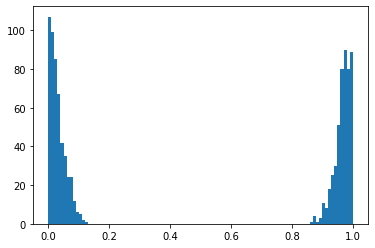

In [67]:
import matplotlib.pyplot as plt

alpha = 0.1
#alpha = 1/(n*np.log(n))

def Dalpha(alpha):
  return mod1(npr.normal(0, alpha/(2*np.pi)**0.5))
  
e = Dalpha(alpha)
print(e)

N = 1000
Sample = np.zeros(N)
for i in range (N):
  Sample[i] = Dalpha(alpha)
plt.hist(Sample, 100)
plt.show()


Le problème est maintenant le suivant. Supposons que nous avons $s \in \mathbb{Z}_q^n$. Nous allons calculer un certain nombre d'images bruités de l'application linéaire, c'est-à-dire que nous calculons un certain nombre de paires $(u_i, t_i) \in \mathbb{Z}_q^n \times \mathbb{S}^1$ : 
$$
t_i = u_i \cdot s + e_i \mod 1
$$
où $e_i$ est un bruit suivant la distribution $D_\alpha$.

Par exemple:

In [68]:
s = vecZqn(q, n)
print(s)

[10  7  3 17  5 12]


In [69]:
N = 7 # taillle de l'échantillon

def creerEchantillon(s, N, alpha, q, n):
  U = np.zeros((N, n))
  T = np.zeros((N, 1))
  for i in range(N):
    U[i, :] = vecZqn(q, n)
    T[i] = addMod( prodScal(s, U[i,:], q)/q , Dalpha(alpha))
  return U, T

U, T = creerEchantillon(s, N, alpha, q, n)

print(U)
print(T)


[[ 2.  5. 10. 14.  0.  5.]
 [13. 11.  5.  4. 12.  9.]
 [ 8.  1. 17.  6. 16.  8.]
 [ 2. 17. 15. 13.  4. 13.]
 [15.  0.  2.  4. 11.  2.]
 [11.  5.  6. 10. 15. 11.]
 [ 8. 17. 13.  6. 16.  1.]]
[[0.58338994]
 [0.99138369]
 [0.52389541]
 [0.11985678]
 [0.87189355]
 [0.76349467]
 [0.35712188]]


Si le vecteur $s$ est connu, on peut retrouver les nombres $e$ de la distribution $D_\alpha$ en calculant 
$$
e_i = u_i \cdot s - t_i
$$

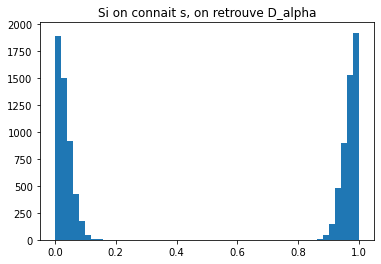

In [70]:
N=10000

U, T = creerEchantillon(s, N, alpha, q, n)

#print(U, T)
def tester(U, T, s2, q, n):
  E = np.zeros_like(U[:,0])
  for i in range(E.size):
    E[i] = addMod( prodScal(s2, U[i,:], q)/q , -T[i, 0])
  return E

E = tester(U, T, s, q, n)
plt.hist(E, 50)
plt.title("Si on connait s, on retrouve D_alpha")
plt.show()




Par contre, si on prend un $s$ quelconque, on obtient plutôt une distribution uniforme.

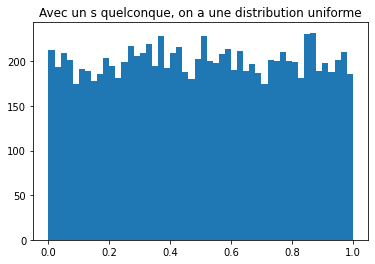

In [71]:
s2 = vecZqn(q, n)
E = tester(U, T, s2, q, n)
plt.hist(E, 50)
plt.title("Avec un s quelconque, on a une distribution uniforme")
plt.show()



En fait même si on perturbe $s$, la distribution sera uniforme. Voici deux exemples, dans le premier on additionne un nombre aléatoire entre -1 et 1 à toutes les composantes de $s$. 

Dans le 2e, on additionne 1 à une seule des composantes. On voit le résultat au niveau de la distribution. 

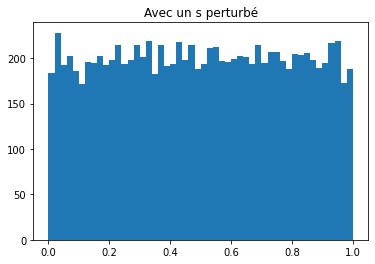

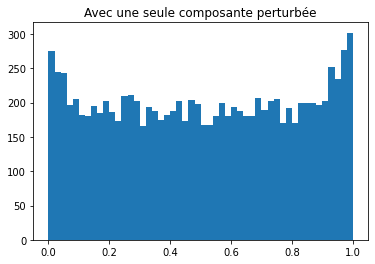

In [72]:
s3 = np.zeros_like(s)
for i in range(n):
  s3[i] = s[i]+npr.randint(-1,2) % q

E = tester(U, T, s3, q, n)
plt.hist(E, 50)
plt.title("Avec un s perturbé")
plt.show()

s[4]=s[4]+1%q
E = tester(U, T, s, q, n)
plt.hist(E, 50)
plt.title("Avec une seule composante perturbée")
plt.show()



## Principe de l'encryption

L'idée est alors très simple pour encrypter. Si on connait $s$ exactement, on retourve la distribution de $D_\alpha$ qui, si $\alpha$ est assez petit, peut être arrondie à 0 (dans $\mathbb{S}^1$) dans le sens suivant : 
$$
\text{arrondi}(x) = 
\begin{cases}
0 & \text{ si } x < 0,25 \text{ ou } x > 0,75  \\
0,5 & \text{ si } 0,25 < x < 0,75
\end{cases}
$$
Si l'on veut encoder un bit $x$ (qui vaut 0 ou 1), on peut alors ajouter $x/2$ aux données de $T$. En faisant ça, en utilisant $s$ pour retrouver la distribution, on obtiendra un résultat qui s'arrondira autour de la valeur de $x/2$, permettant ainsi de retrouver le bit. 

Par contre, comme les graphiques précédents le montrent, si on ne connait pas $s$, le résultat va s'arrondir aléatoirement à 0 ou à 0,5. 


La clé publique est donc les échantillons $U$ et $T$ (ainsi que $q$ et $n$). 

Le principe ci-dessus n'est pas suffisant pour encoder efficacement un bit, puisque si on ajoute la même quantité à tous les éléments de $T$, il serait facile de retrouver l'information en comparant avec les éléments de $T$ initiaux. 

L'idée est donc de prendre un sous-échantillon de $U$ et de $T$ et d'additionner ces éléments. Si la taille de $\alpha$ est assez petite (l'écart-type du bruit), la distribution de la somme s'arrondira quand même à la bonne valeur. 

Formellement, on choisit un sous-échantillon $(V, S)$ de $(U, T)$ et le bit encodé est donc : 
$$
(a, b) = \left ( \sum_{v \in V} v, \frac{x}{2} + \sum_{s \in S} s \right )
$$
Il s'agit donc d'un vecteur dans $a \in \mathbb{Z}_q^n$ et d'un nombre $b \in \mathbb{S^1}$.

Pour décoder, il suffit alors de calculer 
$$
y = \text{arrondi}(a \cdot s - b)
$$


## Implémentation de l'encryption

Pour implémenter le tout, il faut une fonction qui prend un sous-échantillon de $(U, T)$. 

In [73]:
import random as rd 

def sousEchantillon(U, T, taille):
  indices = np.arange(0, U.shape[0])
  ind = rd.sample(list(indices), taille)
  V = U[ind]
  S = T[ind]
  return V, S

V, S = sousEchantillon(U, T, 4)
print(V, S)



[[ 9. 14. 13.  0.  8. 13.]
 [16. 17.  4.  5.  5. 14.]
 [ 9.  4. 15.  8.  2.  8.]
 [12. 12.  1.  1. 10. 17.]] [[0.88968712]
 [0.44932852]
 [0.84357302]
 [0.11008573]]


Maintenant, les fonctions pour encrypter et décrypter. 

In [74]:
# Pour encrypter un bit x.

def encrypter(x, U, T, q, taille):
  V, S = sousEchantillon(U, T, taille)
  a = np.sum(V, 0) % q
  b = mod1(x/2 + np.sum(S))
  return a,b

x = 1

a, b = encrypter(x, U, T, q, 10)

def decrypter(a, b, s, q):
  y = mod1(b - prodScal(a, s, q)/q)
  if y<0.25 or y>0.75:
    y2 = 0
  else: 
    y2=1
  return y2

def decrypterSansArrondi(a, b, s, q):
  y = (b - prodScal(a, s, q)/q)
  return y

print(x, decrypter(a,b,s,q))

1 1


Voici en condensé, tout ce qui est nécessaire pour l'encryption. Les paramètres sont ceux suggérés [ici](https://en.wikipedia.org/wiki/Learning_with_errors). Il faut : 
- Choisir la dimension de l'espace $n$. 
- Choisir le premier $q$, on suggère de le prendre entre $n^2$ et $2n^2$. 
- Choisir la taille de l'échantillon $N$. On suggère $N \approx (1+\epsilon)(n+1)\ln(q)$.
- Choisir $\alpha \approx \frac{n \ln(n)}{\sqrt{2 \pi}}$

In [75]:
# en condensé : 

n = 6 
q = 53  # premier entre n^2 et 2n^2
eps = 1 
N = int((1+eps)*(n+1)*np.log(q)) # taille de l'échantillon.
alpha = 1/(((2*np.pi)**0.5)*n*np.log(n))

s = vecZqn(q, n) # clé privée

U, T = creerEchantillon(s, N, alpha, q, n) # clé publique

x = 1 # bit à encrypter

a, b = encrypter(x, U, T, q, 50)
y = decrypter(a, b, s, q)

print(x, y)



1 1


On teste que le processus est stable: 

In [76]:
M=10000
err = 0
for i in range(M):
  x = npr.randint(0,2)
  a, b = encrypter(x, U, T, q, 50)
  y = decrypter(a, b, s, q)
  if x!=y:
    err += 1
print(err/M)


0.0


Il n'y a aucune erreur.

In [133]:
n = 10
q = 101  # premier entre n^2 et 2n^2
eps = 1 
N = int((1+eps)*(n+1)*np.log(q)) # taille de l'échantillon.
alpha = 1/(((2*np.pi)**0.5)*n*np.log(n))

s = vecZqn(q, n) # clé privée
s2 = vecZqn(q, n)
for i in range(s.size):
  s2[i]=s[i]
s2[4] = q-s2[4]
U, T = creerEchantillon(s, N, alpha, q, n) # clé publique

M=10000
Y0 = np.zeros(M)
Y1 = np.zeros(M)
Y0M = np.zeros(M)
Y1M = np.zeros(M)
for i in range(M):
  a, b = encrypter(0, U, T, q, 50)
  y = mod1(decrypterSansArrondi(a, b, s, q))
  Y0[i]=y
  y = mod1(decrypterSansArrondi(a, b, s2, q))
  Y0M[i]=y
  a, b = encrypter(1, U, T, q, 50)
  y = mod1(decrypterSansArrondi(a, b, s, q))
  Y1[i]=y
  y = mod1(decrypterSansArrondi(a, b, s2, q))
  Y1M[i]=y




[39 94 55  2 37 48 41 58 96 86]
[39 94 55  2 64 48 41 58 96 86]


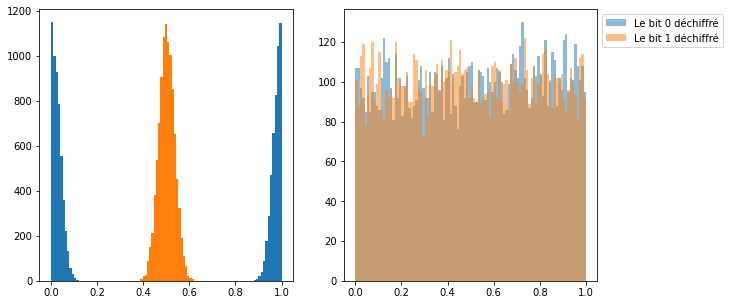

In [151]:
print(s)
print(s2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(Y0, bins=100, label="Le bit 0 déchiffré")
ax1.hist(Y1, bins=25, label="Le bit 1 déchiffré")
#ax1.legend(loc='upper right', bbox_to_anchor=(0.95, 1))

ax2.hist(Y0M, bins=100, label="Le bit 0 déchiffré", alpha=0.5)
ax2.hist(Y1M, bins=100, label="Le bit 1 déchiffré", alpha=0.5)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


## Échange de clé

Dans un contexte où deux personnes voudraient échanger une clé, il est possible d'adapter la situation précédente. 

$A$ et $B$ peuvent chacun se choisir un vecteur secret $s_A$ et $s_B$. Maintenant, on choisit publiquement une matrice $U$ comme précédemment, mais qui serait carrée ($n$ vecteurs dans $ \mathbb{Z}_q^n$). La produit  
$$
s_B^T \,U \,s_A
$$
donne alors un nombre. La distributivité de la transposition sur la multiplication assure que 
$$
s_B^T \,U \,s_A  = [s_B^T \,U \,s_A]^T 
= s_A^T \, U^T \, s_B
$$
Ce qui suggère l'idée suivante pour partagger un secret: 
$A$ calcule la quantité $p_A = U \, s_A + e_A$ et $B$ la quantité $p_B = U^T \, s_B + e_B$, où $e_A$ et $e_B$ sont des vecteurs d'erreurs. Ils peuvent alors s'échanger $p_A$ et $p_B$ et calculer :  
$$
k_A = s_A^T p_B 
$$
et 
$$ 
k_B = s_B^T p_A
$$
Ces deux vecteurs doivent être proches. Le tout n'est pas aussi simple, mais peut être modifié pour avoir un algorithme d'échange de clé. 




Dans [l'article suivant](https://eprint.iacr.org/2012/688.pdf), on propose que les vecteurs d'erreurs soient petits et on fait plutôt : 
$$p_A = U \, s_A + 2e_A, \quad p_B = U^T \, s_B + 2e_B$$
$k_A$ et $k_B$ sont encuite calculés comme précedemment. La quantité $k_A - k_B$ est donc paire et donc 
$$
k_A \mod 2 = k_B \mod 2
$$ 
ce qui est le secret partagé entre les deux, ce qui est illustré dans le code ci-dessous. 

In [79]:
n = 6 
q = 53  # premier entre n^2 et 2n^2
eps = 1 
N = int((1+eps)*(n+1)*np.log(q)) # taille de l'échantillon.
alpha = 1/(((2*np.pi)**0.5)*n*np.log(n))

sA = vecZqn(2, n) 
sB = vecZqn(2, n) 


U = np.zeros((n, n))
EA = npr.randint(-1,2,n)
EB = npr.randint(-1,2,n)

for i in range(n):
  U[i, :] = vecZqn(q,n)

def mod1Arr(M):
  for i in range (M.size):
    M[i] = mod1(M[i])
  return M
 
pA = (np.matmul(U, sA) + 2*EA ) % q
pB = (np.matmul(U.T, sB) + 2*EB  ) % q

kA = np.matmul(sA.T, pB) % q
kB = np.matmul(sB.T, pA) % q
print(kA, kB)

kA2 = kA % 2
kB2 = kB % 2
print(kA2, kB2)


10.0 12.0
0.0 0.0


Ceci est l'idée générale de l'algorithme, mais il faut le modifier sensiblement pour éliminer certains biais. 


# CRYSTALS KYBER et SABER

Crystal Kyber et SABER, deux algorithmes qui sont toujours en lice pour le concours de NIST sont des  adaptations du problème LWE. Les détails sont ici : 
- [KYBER](https://eprint.iacr.org/2017/634.pdf). 
- [SABER](https://eprint.iacr.org/2018/230.pdf). 

L'encryption avec LWE telle que décrite ci-dessus ne permet que de transmettre un bit à la fois. Pour en transmettre plusieurs, on peut répéter le processus plusieurs fois, mais ceci peut ouvrir la porte à des faiblesses. 

L'approche de ces algorithmes est plutôt de travailler avec des polynômes tronqués au lieu de des entiers. C'est à dire qu'on travaille sur 
$$
R_q = \mathbb{Z}_q[X]/(X^n-1)
$$
au lieu de simplement $\mathbb{Z}_q$. Ceci permet de transférer $n$ bits à la fois. Kyber propose un algorithme avec un $q=7681$ et $n=256$ fixe, ce qui permet donc de transférer des clés de taille 256 en une seule opération. 

Le principe est essentiellement le même. 

Les détails de ces algorithmes et une implémentation assez complète de KYBER peut être trouvée [ici](https://colab.research.google.com/drive/18Dvg78wFoBKCy_tcalD4SiQDmYqNQSYK#scrollTo=dbH23qlycjSo). 